In [1]:
%run "candidate_hgt_fxns.ipynb"

orig_blast_path = "/pool001/parsonsc/metazoanHgt/blastHits/cluster40/blastHitsNamesAndClusters.txt"
blast_path = "/home/parsonsc/metazoanHGT/blastResultsBest.tsv"

fasta_path = "fullTrees/cluster40/"
alignment_path = "fullTrees/cluster40/alignments/"
tree_path = "fullTrees/cluster40/trees/"

In [2]:
dists = {}

with open("dists.txt") as f:
    cur = ""
    for line in f:
        if line[1] == ".":
            dists[cur].append(float(line.strip())) 
        else:
            if cur and (dists[cur] == []):
                dists[cur] = [10]
            cur = line.strip()
            dists[cur] = []

sorted_clusters = sorted(list(dists.keys()), key=lambda x:max(dists[x]))
dists = {x:max(dists[x]) for x in sorted_clusters}
#print(dists)

In [3]:
if blast_path.split("/")[-1] not in os.listdir():
    taxonomy_by_cluster = split_blast_by_domain(orig_blast_path, write_path=new_blast_path)

In [4]:
# Figure out the names of the proteins
clustAnnotations = {}
favCutoff = "40"
direc = "/pool001/parsonsc/metazoanHgt/blastClusters/cluster" + favCutoff + "/"
#print([x for x in os.listdir(direc) if (x.split('.')[-1] == "fasta" and x[0] == "c")][0])
tooGeneric = ["domain-containingXoXoXprotein", "containingXoXoXprotein", 
              "repeatXoXoXprotein", "hypotheticalXoXoXprotein"]
for file in [x for x in os.listdir(direc) if (x.split('.')[-1] == "fasta" and x[0] == "c")]:
    #print(file)
    f = open(direc + file)
    names = [x for x in f.readlines() if x[0] == ">"]
    f.close()
    wordBag = {}
    for name in names:
        parts = name.split("[")[0].split(":")[-1].split()[1:]
        combos = ["XoXoX".join(parts[x:y]) for x, y in combinations(
                    range(len(parts) + 1), r=2) if len(parts[x:y]) > 1]
        for combo in combos:
            if combo in tooGeneric:
                continue
            if combo in wordBag:
                wordBag[combo] += 1
            else:
                wordBag[combo] = 1
    sortedParts = sorted(wordBag.items(), key=lambda x: x[1])
    sortedParts.reverse()
    bestChances = [x for x in sortedParts if x[1] > sortedParts[0][1] / 2]
    best = ("a", 0)
    for name, num in bestChances:
        numParts = len(name.split("XoXoX"))
        if numParts > best[1]:
            best = (name, numParts)
    clustAnnotations[file.split('.')[0]] = [best[0].replace("XoXoX", "_"), 100*round(wordBag[best[0]]/len(names), 3)]
    #print(best)
#print(nameDict)

same_name = {}
for x in clustAnnotations:
    ann = clustAnnotations[x][0]
    if ann not in same_name:
        same_name[ann] = [x]
    else:
        same_name[ann].append(x)

for x in dists:
    if x not in clustAnnotations:
        clustAnnotations[x] = [None, None]

In [5]:
favCutoff = "40"
f = open("/pool001/parsonsc/metazoanHgt/blastHits/cluster" + favCutoff + "/blastHitsNamesAndClusters.txt")
flines = [line.strip() for line in f]
f.close()

clusters = {}
for line in flines:
    seq, clust, tids, dom = line.split()
    clusts = clust.split(',')
    for c in clusts:
        if c in clusters:
            clusters[c].append(seq)
        else:
            clusters[c] = [seq]
            
for x in dists:
    if x not in clusters:
        clusters[x] = []
        


[(1.1186650603000001, 'h_L16'), (1.4355006121000002, 'h_L18'), (1.5009257258000002, 'h_S8'), (1.6504758118999998, 'h_L15'), (1.7009863387, 'h_L3'), (1.8097017782, 'h_L2'), (1.9182870887999999, 'h_S19'), (2.0481433571, 'h_L4'), (2.1271732161, 'h_L6'), (2.2115206877, 'h_L5'), (2.2369845734, 'h_L24'), (2.3138070611, 'h_S17'), (2.3334634980000004, 'h_S10'), (2.3905250063, 'h_L14'), (2.6322303631, 'h_S3'), (3.0804468592000003, 'h_L22')]


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=0.2820893729973896, pvalue=0.8684505028182972)


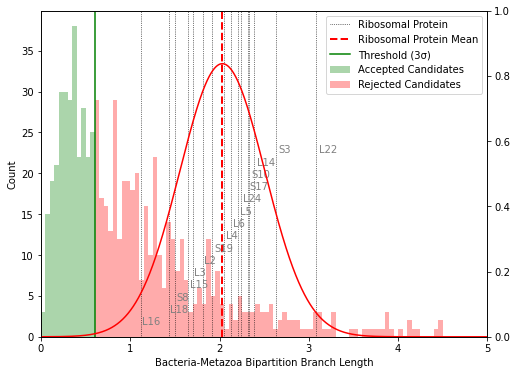

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
blastMax = [dists[x] for x in dists if x[0] == "c"]
#ax.hist(blastMax, bins=100,range=(0,5), alpha=0.33, color='blue', label="BLAST Max",zorder=-100)

#print([x for x in dists])
hugLens = [(dists[x], x) for x in dists  if x[0] == "h"]
print(hugLens)
hugDistsOnly = [dist for dist,name in hugLens]
count = 0
for xc, name in hugLens[:-1]:
    #if xc < 2:
        #print(name)
        #continue
    ax.axvline(x=xc, lw = 0.7, color="black", linestyle=":")
    count += 1
    ax.text(xc*1.01, 1.5*count,name[2:],zorder=100,color="gray")
xc,name = hugLens[-1]
ax.text(xc*1.01, 1.5*count,name[2:],zorder=100,color="gray")
ax.axvline(x=xc, lw = 0.7, color="black", linestyle=":", label="Ribosomal Protein")

ax.axvline(x=np.mean(hugDistsOnly), lw = 2, color="red",linestyle="--", label="Ribosomal Protein Mean")

x_axis = np.arange(0, 5, 0.001)
ax2 = ax.twinx()
ax2.plot(x_axis, stats.norm.pdf(x_axis,np.mean(hugDistsOnly),np.std(hugDistsOnly)), color="red")
ax2.set_ylim(0, 1)
threshold = np.mean(hugDistsOnly) - 3*np.std(hugDistsOnly)
num_under = len([x for x in blastMax if x < threshold])
ax.axvline(threshold, label="Threshold (3σ)", color="green")

ax.hist([x for x in blastMax if x<threshold], bins=int(100*(threshold/5)),range=(0,threshold), alpha=0.33, color='green', label="Accepted Candidates",zorder=-100)
ax.hist([x for x in blastMax if x>=threshold], bins=math.ceil(100*(1-(threshold/5))),range=(threshold,5), alpha=0.33, color='red', label="Rejected Candidates",zorder=-100)

ax.legend()
ax.set_xlim(0,5)
ax.set_xlabel("Bacteria-Metazoa Bipartition Branch Length")
ax.set_ylabel("Count")
print(stats.normaltest(hugDistsOnly))

#print([y for x in dists for y in dists[x] if x[0] == "c"])
#print([(x, y) for x in dists for y in dists[x] if x[0] != "c"])
#print([(x, dists[x]) for x in dists if x[0] == "c" and max(dists[x]) < 0.5])

In [7]:
metazoa_only = ["c_3788","c_6295","c_7891","c_26458","c_13712",
                "c_18732","c_1634","c_8622","c_3876","c_23861",
                "c_6299","c_13542","c_3648","c_2582","c_12510",
                "c_11959","c_17088","c_24640","c_2617","c_11604",
                "c_138","c_2616","c_10262","c_2480","c_323",
                "c_9671","c_2521","c_22429","c_6786","c_13957",
                "c_8295","c_1215","c_14038","c_23187","c_8079",
                "c_3765","c_69114"]

dataframe = pd.DataFrame([[x, *clustAnnotations.get(x), dists.get(x), len(clusters[x])] for x in dists if dists.get(x)<threshold],
                        columns=["cluster","annotation","conf","first pass","hits"])
dataframe_full = pd.DataFrame([[x, *clustAnnotations.get(x), dists.get(x), len(clusters[x])] for x in dists],
                        columns=["cluster","annotation","conf","first pass","hits"])

dataframe_metonly = pd.DataFrame([[x, *clustAnnotations.get(x), dists.get(x), len(clusters[x])] for x in dists if x in metazoa_only],
                        columns=["cluster","annotation","conf","first pass","hits"])



Text(0, 0.5, 'Metazoa-Bacteria Biparition Length')

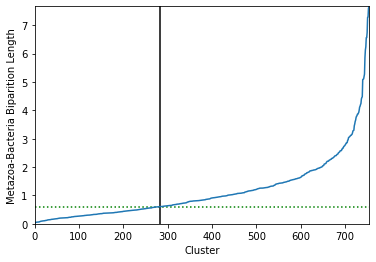

In [8]:
fig, ax = plt.subplots()
dists_ordered = [dists.get(x) for x in dists if dists.get(x) != 10]
ax.plot(range(len(dists_ordered)), dists_ordered)
ax.hlines(threshold, 0, len(dists_ordered),color="green",linestyle=":")
ax.hlines(threshold, 0, np.mean(hugDistsOnly),color="red",linestyle=":")
ax.vlines(num_under, 0, 10,color="black")

ax.set_xlim(0, len(dists_ordered))
ax.set_ylim(0, max(dists_ordered))
ax.set_xlabel("Cluster")
ax.set_ylabel("Metazoa-Bacteria Biparition Length")

In [9]:
# Download 10x 300-sequence sets for each cluster
for i in range(num_under):
    clear_output(wait=True)
    clust = dataframe.iloc[i]["cluster"]
    if clust + "_10.fasta" in os.listdir("fullTrees/cluster40/"):
        if clust + "_10.afa" not in os.listdir("fullTrees/cluster40/alignments"):
            print(clust+": already found, but unaligned")
        else:
            print(clust+": already found")
        continue
    print(clust+": downloading...")
    groupdict, taxdict = generate_small_alignments(clust, blast_path, n=10, batch_size=300)

c_13119: already found


In [10]:
update_all_names("fullTrees/cluster40/alignments/")

Renaming c_2783_full.afa
Renaming c_1606_full.afa
Renaming c_153_full.afa
Renaming c_1208_full.afa
Renaming c_12049_full.afa
Renaming c_10474_full.afa
Renaming c_12875_full.afa
Renaming c_10866_full.afa
Renaming c_1312_full.afa
Renaming c_13553_full.afa
Renaming c_21872_full.afa
Renaming c_2034_full.afa
Renaming c_5593_full.afa
Renaming c_14327_full.afa
Renaming c_10560_full.afa
Renaming c_3982_full.afa
Renaming c_7963_full.afa
Renaming c_11702_full.afa
Renaming c_3429_full.afa
Renaming c_1967_full.afa
Renaming c_9407_full.afa
Renaming c_4867_full.afa
Renaming c_23300_full.afa
Renaming c_11477_full.afa
Renaming c_17160_full.afa
Renaming c_12318_full.afa
Renaming c_13362_full.afa
Renaming c_138_full.afa
Renaming c_1380_full.afa
Renaming c_11001_full.afa
Renaming c_7173_full.afa
Renaming c_9843_full.afa
Renaming c_3288_full.afa
Renaming c_10655_full.afa
Renaming c_2924_full.afa
Renaming c_3992_full.afa
Renaming c_1124_full.afa
Renaming c_3311_full.afa
Renaming c_8386_full.afa
Renaming c_

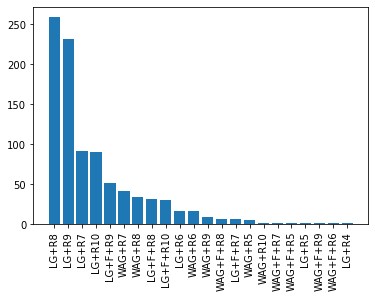

In [11]:
alignment_path = "fullTrees/cluster40/alignments/"
tree_path = "fullTrees/cluster40/trees/"
orig_tree_path = "/pool001/parsonsc/metazoanHgt/trees/cluster40/"


cluster_models = {}
for file in os.listdir(orig_tree_path):
    if file[-4:] != ".log":
        continue
    with open(orig_tree_path+file) as f:
        lines = [x.strip() for x in f.readlines()]
        if len(lines) < 100:
            continue
        model_line = [x for x in lines if "Bayesian Information Criterion:" in x][0]
        model = model_line.split()[-1].strip()
        clust = file.split(".")[0][3:]
        cluster_models[clust] = model
#print(cluster_models)

fig, ax = plt.subplots()
all_models = list(cluster_models.values())
labels = list(set(all_models))
counts = [len([y for y in all_models if y==x]) for x in labels]
counts, labels = zip(*sorted(zip(counts, labels), reverse=True))
plt.xticks(rotation=90)

a = ax.bar(labels,counts)

In [12]:
alignment_path = "fullTrees/cluster40/alignments/"
tree_path = "fullTrees/cluster40/trees/"
orig_tree_path = "/pool001/parsonsc/metazoanHgt/trees/cluster40/"
afas = [file for file in os.listdir(alignment_path) if "_rn.afa" in file and "full" not in file]
afas = [x for x in afas if x.split(".")[-1]=="afa"]
afas = sorted(afas, key=lambda x:x.split("_")[2])

#print(afas)
for afa in afas:
    if afa + ".log" in os.listdir(tree_path)+os.listdir(alignment_path):
        continue
    clust = "_".join(afa.split("_")[:2])
    if clust not in cluster_models:
        print("No model found for %s, using LG+R8"%(clust))
        model = "LG+R8"
    else:
        model = cluster_models[clust]
    print(afa,clust,model)
    name = afa.replace("_rn.afa","_rn_iqtree")
    commands = ["module add engaging/iqtree/1.6.3",
                "iqtree -s " + alignment_path + afa + 
                " -nt 2 -bb 1000 -alrt 1000 -m " + model,#+ " -mset LG -msub nuclear",
                "mv " + alignment_path + afa + ".* " + tree_path]
    iqtreeSh = makeShell(name, commands, mem = "5", cores="2", max_queue="100")    
    completed = subprocess.run(["sbatch", iqtreeSh])

c_22429_4_rn.afa c_22429 LG+R9
c_2771_4_rn.afa c_2771 LG+R7
c_2262_4_rn.afa c_2262 LG+R8
c_6952_4_rn.afa c_6952 LG+R8
c_25148_4_rn.afa c_25148 LG+R9
c_20400_4_rn.afa c_20400 LG+R10
c_11341_4_rn.afa c_11341 LG+R9
c_3608_4_rn.afa c_3608 LG+R8
c_1124_4_rn.afa c_1124 LG+R7
c_2677_4_rn.afa c_2677 LG+R9
c_8622_4_rn.afa c_8622 LG+R9
c_12318_4_rn.afa c_12318 WAG+R7
c_26826_4_rn.afa c_26826 LG+F+R7
c_12650_4_rn.afa c_12650 LG+R9
c_6295_4_rn.afa c_6295 LG+R6
c_2159_4_rn.afa c_2159 LG+F+R8
c_13957_4_rn.afa c_13957 LG+R8
c_1113_4_rn.afa c_1113 LG+R9
c_19989_4_rn.afa c_19989 LG+R9
c_11044_4_rn.afa c_11044 LG+R8
c_3270_4_rn.afa c_3270 LG+R9
c_2619_4_rn.afa c_2619 LG+F+R9
c_3992_4_rn.afa c_3992 LG+R8
c_5214_4_rn.afa c_5214 LG+R6
c_2146_4_rn.afa c_2146 LG+R10
c_12875_4_rn.afa c_12875 LG+R7
c_1104_4_rn.afa c_1104 WAG+R8
c_9902_4_rn.afa c_9902 LG+F+R10
c_21872_4_rn.afa c_21872 LG+R9
c_8313_4_rn.afa c_8313 LG+R8
c_26293_4_rn.afa c_26293 LG+R10
c_7327_4_rn.afa c_7327 LG+R9
c_24989_4_rn.afa c_24989 WAG+R7


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cb295f4cb3d0>", line 24, in <module>
    iqtreeSh = makeShell(name, commands, mem = "5", cores="2", max_queue="100")
  File "<ipython-input-1-cbb01b356041>", line 27, in makeShell
    subprocess.call(["while [ $( squeue -u parsonsc | wc -l) -gt " + max_queue + " ]; do\n    sleep 10; done;"], shell=True)
  File "/home/software/anaconda3/2020.11/lib/python3.8/subprocess.py", line 342, in call
    return p.wait(timeout=timeout)
  File "/home/software/anaconda3/2020.11/lib/python3.8/subprocess.py", line 1079, in wait
    return self._wait(timeout=timeout)
  File "/home/software/anaconda3/2020.11/lib/python3.8/subprocess.py", line 1804, in _wait
    (pid, sts) = self._try_wait(0)
  File "/home/software/anaconda3/2020.11/lib/python3.8/subprocess.py", lin


KeyboardInterrupt



In [14]:
dist_dict = {}
full_dist_dict = {}
for file in os.listdir(tree_path):
    if file.split(".")[-1] != "treefile" or "labelled" in file:
        continue
    tree = ete3.Tree(tree_path+file, format=1)
    clear_output(wait=True)
    tree_dists = calculateMBDistance(tree)
    print(file, tree_dists)
    if "full" in file:
        full_dist_dict[file] = tree_dists
    else:
        dist_dict[file] = tree_dists

clust_dist_dict = {}
means, meds, ranges, bp_counts = [],[],[],[]
for clust in dataframe.loc[:,"cluster"]:
    clust_bps = [max(dist_dict[x]) for x in dist_dict if clust in x and dist_dict[x] != []]
    bp_counts.append([len(dist_dict[x]) for x in dist_dict if clust in x])
    if clust_bps != []:
        ind = dataframe["cluster"] == clust
        means.append(np.mean(clust_bps))
        meds.append(np.median(clust_bps))
        ranges.append(np.max(clust_bps) - np.min(clust_bps))
        clust_dist_dict[clust] = clust_bps
    else:
        means.append(None)
        meds.append(None)
        ranges.append(None)

if "mean" not in dataframe.columns.tolist():
    dataframe.insert(dataframe.shape[-1], "mean", means)
    dataframe.insert(dataframe.shape[-1], "median", meds)
    dataframe.insert(dataframe.shape[-1], "range", ranges)
else:
    dataframe.loc[:,"mean"] = means
    dataframe.loc[:,"median"] = meds
    dataframe.loc[:,"range"] = ranges

c_44045_4_rn.afa.treefile [0.3539645243]


Text(0, 0.5, 'Count')

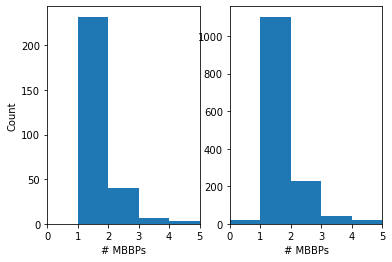

In [15]:
present = [x for x in dataframe.loc[:,"cluster"].tolist() if x in clust_dist_dict]
fig, ax = plt.subplots(1,2,sharex=True)
ax[0].hist([np.median(x) for x in bp_counts],range=(0,5), bins=5)
ax[0].set_xlim(0,5)
ax[1].hist([x for xs in bp_counts for x in xs],range=(0,5), bins=5)
ax[1].set_xlim(0,5)
ax[0].set_xlabel("# MBBPs")
ax[1].set_xlabel("# MBBPs")
ax[0].set_ylabel("Count")
#ax.set_xlim(0,len(present)+1)

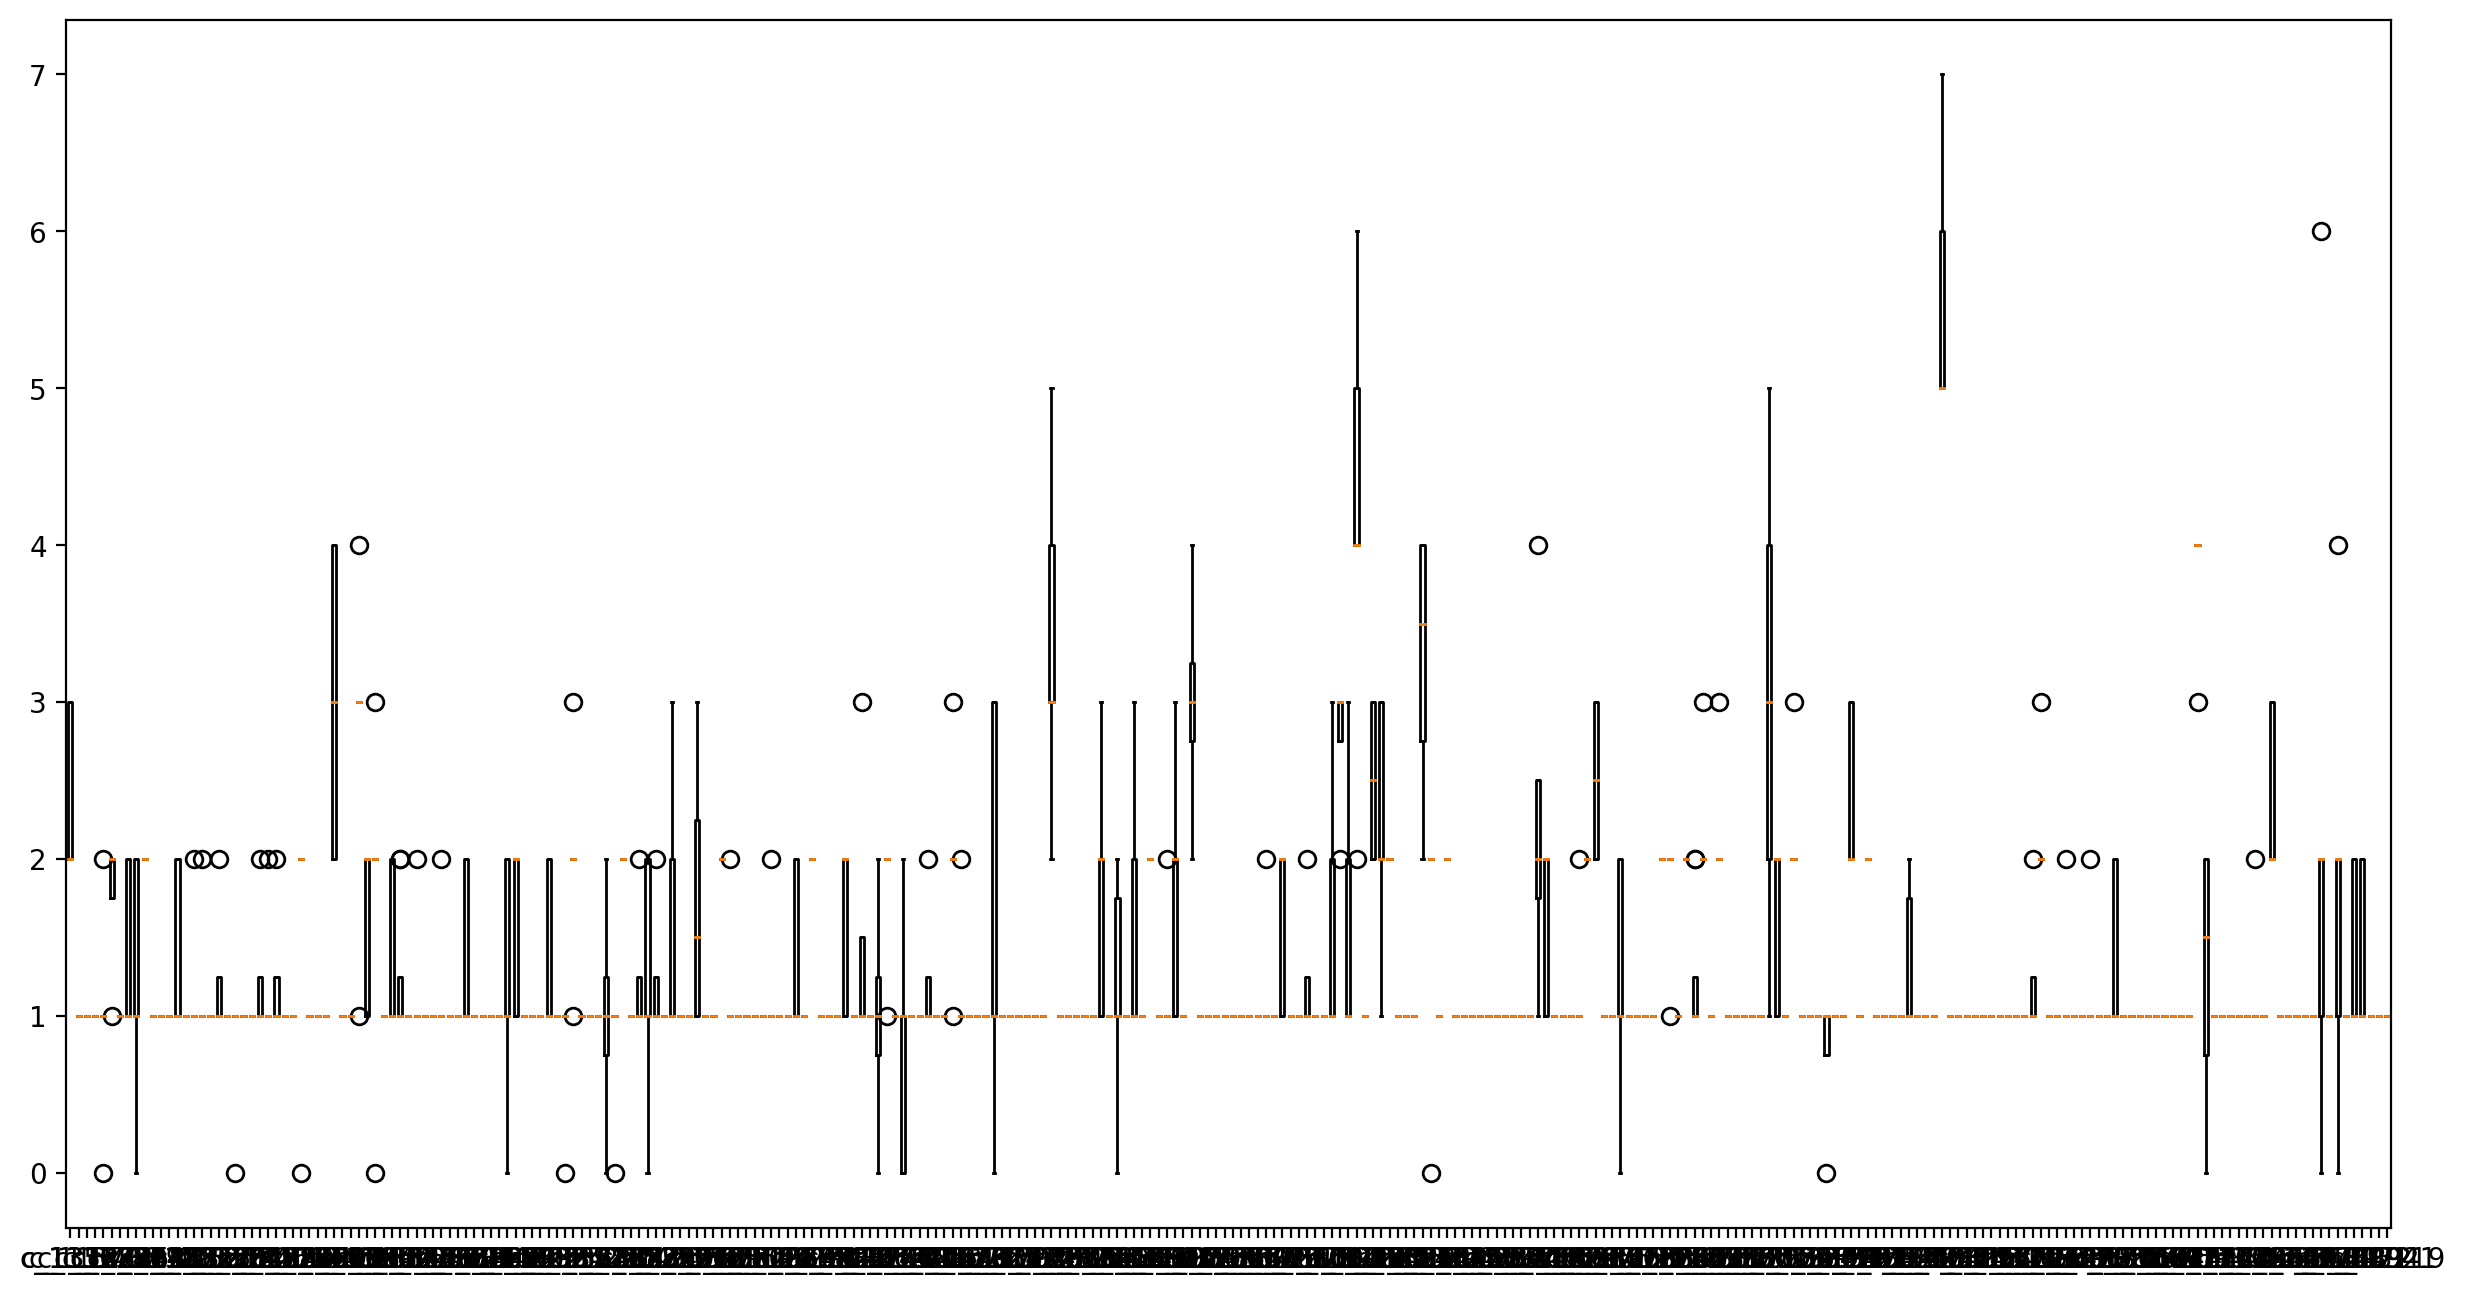

In [16]:
fig, ax = plt.subplots(figsize=(15,8),dpi=200)

a = ax.boxplot(bp_counts, labels=present)

282 clusters found


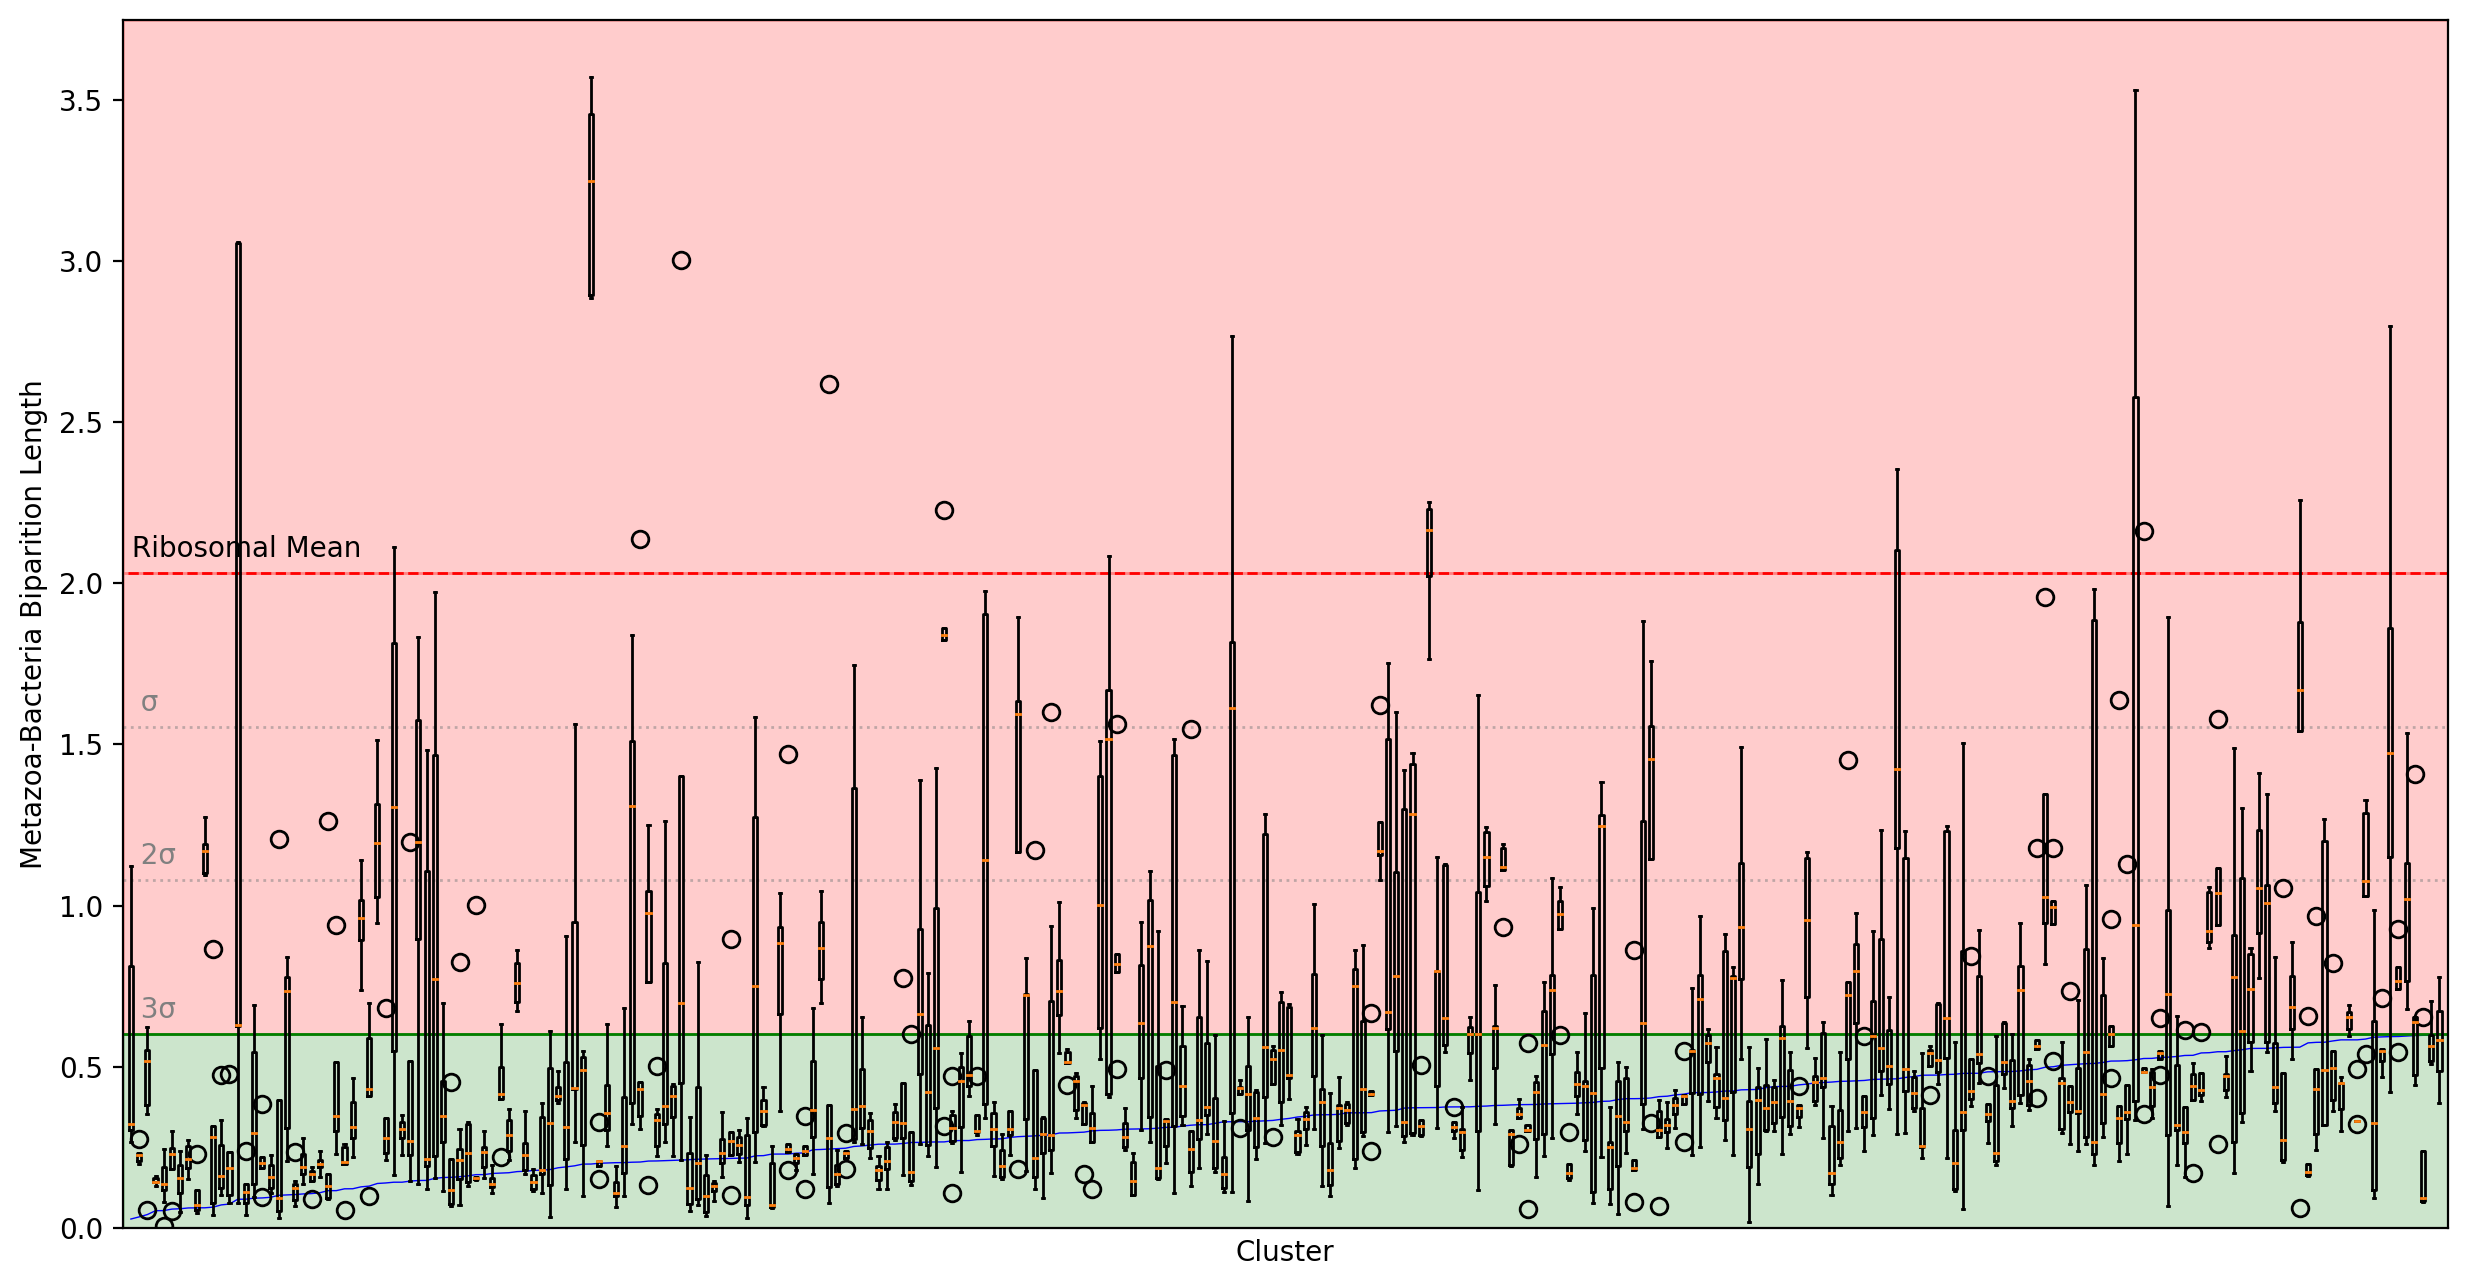

In [17]:
#%run "candidate_hgt_fxns.ipynb"
fig, ax = plt.subplots(figsize=(15,8),dpi=200)
num_clusts = len(clust_dist_dict)

"""for i in range(1,num_under+1):
    clust = dataframe.iloc[i-1]["cluster"]
    if clust not in clust_dist_dict:
        continue
    else:
        samples = clust_dist_dict[clust]
        n_samples = len(samples)
        ax.scatter([i]*n_samples, samples,marker=".")
"""
sorted_by_mean = sorted(clust_dist_dict.keys(), key=lambda x:np.mean(clust_dist_dict[x]))
sorted_by_median = sorted(clust_dist_dict.keys(), key=lambda x:np.median(clust_dist_dict[x]))

sort_by = clust_dist_dict
clust_dist_dict_sorted = {x:clust_dist_dict[x] for x in sort_by}

range_threshold = 0.5
ranges = {x:calc_range(clust_dist_dict_sorted[x]) for x in clust_dist_dict_sorted}
range_limited = {x:clust_dist_dict_sorted[x] for x in clust_dist_dict_sorted if ranges[x]  < range_threshold}
ranges_no_outliers = {x:calc_range(clust_dist_dict_sorted[x], exclude_outliers=True) for x in clust_dist_dict_sorted}
range_limited_no_outliers = {x:clust_dist_dict_sorted[x] for x in clust_dist_dict_sorted if ranges_no_outliers[x] < range_threshold}
iqr_threshold = 0.25
iqrs = {x:calc_iqr(clust_dist_dict_sorted[x]) for x in clust_dist_dict_sorted}
iqr_limited = {x:clust_dist_dict_sorted[x] for x in clust_dist_dict_sorted if iqrs[x] < iqr_threshold}
median_threshold = threshold
iqr_limited = {x:clust_dist_dict_sorted[x] for x in clust_dist_dict_sorted if np.median(clust_dist_dict_sorted[x]) < median_threshold}



clust_dist_dict_sorted = clust_dist_dict_sorted

#print([str(i) if i%5==0 else "" for i in range(1,num_clusts+1)])
ax.boxplot(clust_dist_dict_sorted.values(), labels=clust_dist_dict_sorted.keys())
present = [x for x in dataframe["cluster"].tolist() if x in clust_dist_dict_sorted]
#ax.scatter(range(1,len(present)+1), [dists[x] for x in present],zorder=-99,color="blue",marker="_",s=0.5)
ax.plot(range(1,len(present)+1), [dists[x] for x in present],zorder=-99,color="blue",linewidth=0.5)

#ax.plot(range(len(dists_ordered))[:num_under], dists_ordered[:num_under])
ax.hlines(np.mean(hugDistsOnly),threshold,num_clusts+2, color="red",linestyle="--",linewidth=1)
ax.text(0, np.mean(hugDistsOnly)+0.05, " Ribosomal Mean", color="black")
ax.hlines(threshold,0,num_clusts+2, color="green",linewidth=1)
ax.text(0,threshold+0.05,"  3σ", color="gray")
ax.hlines(np.mean(hugDistsOnly)-np.std(hugDistsOnly),0,num_clusts+2, alpha=0.5,color="gray",linestyle=":",linewidth=1)
ax.text(0,np.mean(hugDistsOnly)-np.std(hugDistsOnly)+0.05,"  σ", color="gray")
ax.hlines(np.mean(hugDistsOnly)-2*np.std(hugDistsOnly),0,num_clusts+2, alpha=0.5,color="gray",linestyle=":",linewidth=1)
ax.text(0,np.mean(hugDistsOnly)-2*np.std(hugDistsOnly)+0.05,"  2σ", color="gray")

ax.set_xlim(0,len(clust_dist_dict_sorted)+1)
ax.set_ylim(0, None)
ax.set_xlabel("Cluster")
ax.set_ylabel("Metazoa-Bacteria Biparition Length")
ax.set_xticks([])

#ax.vlines(range(1,num_under+1),0,ax.get_ylim()[-1],linewidth=0.5)

ax.fill_between(range(num_clusts+2), 0, threshold,zorder=-100,color="green",alpha=0.2)
ax.fill_between(range(num_clusts+2), threshold, np.mean(hugDistsOnly), zorder=-100, color="red",alpha=0.2)
ax.fill_between(range(num_clusts+2), np.mean(hugDistsOnly), ax.get_ylim()[-1],zorder=-100, color="red",alpha=0.2)

print(num_clusts, "clusters found")

In [14]:
fastas = [x for x in os.listdir("fullTrees/cluster40/") if ".fasta" in x]
#for clust in metazoa_only:
for clust in dataframe.loc[:,"cluster"]:
    fasta_file = clust + "_full.fasta"
    #clust = dataframe.iloc[i]["cluster"]
    if clust + "_full.fasta" in fastas:
        if clust + "_full.afa" in os.listdir("fullTrees/cluster40/alignments"):
            print(clust+": already found")
            continue
        else:
            print(clust+": already found, but unaligned")
    else:
        clust_fastas = ["fullTrees/cluster40/"+x for x in fastas if clust in x]
        print(clust+": combining...")
        combine_fastas(clust_fastas, "fullTrees/cluster40/"+clust + "_full.fasta")
    makeAlignment(clust+"_full", [], max_queue="250")
    #groupdict, taxdict = generate_small_alignments(clust, blast_path, n=0, batch_size=0)
    #update_default_names("fullTrees/cluster40/alignments/"+clust+"_full.afa", taxdict, groupdict)


c_1312: already found
c_13547: already found
c_11546: already found
c_11883: already found
c_3981: already found
c_3788: already found
c_6295: already found
c_12748: already found
c_7891: already found
c_712: already found
c_8247: already found
c_26458: already found
c_7922: already found
c_383: already found
c_413: already found
c_13712: already found
c_1857: already found
c_20766: already found
c_3270: already found
c_5214: already found
c_16644: already found
c_15043: already found
c_26826: already found
c_26293: already found
c_3579: already found
c_24989: already found
c_24012: already found
c_18732: already found
c_2219: already found
c_11789: already found
c_14346: already found
c_26218: already found
c_5593: already found
c_26198: already found
c_1605: already found
c_13187: already found
c_10135: already found
c_13649: already found
c_3994: already found
c_1634: already found
c_2677: already found
c_8622: already found
c_11591: already found
c_3436: already found
c_12417: alre

In [15]:
update_all_names("fullTrees/cluster40/alignments/")

c_26198 -- metazoa:70,bacteria:6700,other:2216
Renaming c_26198_full.afa
c_12498 -- metazoa:96,bacteria:4936,other:3859
Renaming c_12498_full.afa
c_3270 -- metazoa:58,bacteria:8221,other:988
Renaming c_3270_full.afa
c_12417 -- metazoa:48,bacteria:6919,other:1117
Renaming c_12417_full.afa
c_11789 -- metazoa:81,bacteria:7173,other:1707
Renaming c_11789_full.afa
c_17810 -- metazoa:74,bacteria:7269,other:2479
Renaming c_17810_full.afa
c_3082 -- metazoa:66,bacteria:7794,other:1085
Renaming c_3082_full.afa
c_9902 -- metazoa:269,bacteria:3500,other:3334
Renaming c_9902_full.afa
c_2521 -- metazoa:567,bacteria:3031,other:92
Renaming c_2521_full.afa
c_26826 -- metazoa:63,bacteria:8874,other:267
Renaming c_26826_full.afa
c_24989 -- metazoa:79,bacteria:6837,other:2095
Renaming c_24989_full.afa
c_13547 -- metazoa:65,bacteria:8143,other:1082
Renaming c_13547_full.afa
c_20766 -- metazoa:74,bacteria:7605,other:1496
Renaming c_20766_full.afa
c_24012 -- metazoa:67,bacteria:7404,other:1851
Renaming c_240

In [77]:
alignment_path = "fullTrees/cluster40/alignments/"
tree_path = "fullTrees/cluster40/trees/"
orig_tree_path = "/pool001/parsonsc/metazoanHgt/trees/cluster40/"
full_afas = [file for file in os.listdir(alignment_path) if "_full_rn.afa" in file]
full_afas = [x for x in full_afas if x.split(".")[-1]=="afa"]
#print(afas)
for afa in full_afas:
    if afa + ".treefile" in os.listdir(tree_path)+os.listdir(alignment_path):
        continue
    print(afa)
    name = afa.replace("_rn.afa","_rn_iqtree")
    commands = ["module add engaging/iqtree/1.6.3",
                "iqtree -s " + alignment_path + afa + 
                " -nt 5 -bb 1000 -alrt 1000 -m MFP -mset WAG,LG,JTT -msub nuclear",
                "mv " + alignment_path + afa + ".* " + tree_path]
    iqtreeSh = makeShell(name, commands, mem = "15", cores="5", max_queue="80")    
    completed = subprocess.run(["sbatch", iqtreeSh])


c_26198_full_rn.afa
c_3579_full_rn.afa
c_32712_full_rn.afa
c_26592_full_rn.afa
c_27186_full_rn.afa
c_10527_full_rn.afa
c_2972_full_rn.afa
c_14346_full_rn.afa
c_3436_full_rn.afa
c_1824_full_rn.afa
c_11883_full_rn.afa
c_422_full_rn.afa
c_51871_full_rn.afa
c_22140_full_rn.afa
c_6869_full_rn.afa
c_3569_full_rn.afa
c_3454_full_rn.afa
c_6952_full_rn.afa
c_1511_full_rn.afa
c_20713_full_rn.afa
c_25148_full_rn.afa
c_17587_full_rn.afa
c_9838_full_rn.afa


In [ ]:
#

In [ ]:
#Label tree files with taxonomy
treefiles = [x for x in os.listdir(tree_path) if x.split(".")[-1] == "treefile" and ".afa." in x]
clusts_with_trees = list(set(["_".join(x.split("_")[:2]) for x in treefiles]))
# sorting by initial mbbp value
clusts_with_trees = [x for x in dataframe["cluster"].tolist() if x in clusts_with_trees]
if "labelled" not in os.listdir(tree_path):
    subprocess.run(["mkdir", tree_path+"labelled"])
for clust in clusts_with_trees:
    clust_treefiles = [x for x in treefiles if clust in x]

    if clust + "_full_rn.afa.treefile" not in clust_treefiles:
        continue
    subprocess.run(["rm", tree_path+clust+"_labelled.treefile"])
    subprocess.run(["rm", tree_path+"labelled/"+clust+"_labelled.treefile"])
    if clust+"_labelled.treefile" in os.listdir(tree_path+"labelled/"):
        print(clust, "already found")
        continue
    print(clust, len(clust_treefiles))
    trees={}
    linDict, rankDict, nameDict = {},{},{}
    for label in ["full"] + [str(x) for x in range(1,11)]:
        run = clust+"_"+label
        treefile = run+"_rn.afa.treefile"
        if run+"_rn.afa.treefile" in clust_treefiles:
            trees[run] = ete3.Tree(tree_path+treefile, format=1)
            for node in trees[run].traverse():
                if node.is_leaf():
                    node.name = list(node.name)
                    for i in [1,2]:node.name[node.name.index("_")] = "|"
                    node.name = "".join(list(node.name))
    out_path = tree_path+"labelled/"+clust+"_labelled.treefile"
    linDict, rankDict, nameDict = merge_and_write_trees(clust, trees, out_path, sort_by=None, 
                                                        linDict=linDict, rankDict=rankDict, 
                                                        nameDict=nameDict,reuse=True)

c_3788 5
c_3788_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2589859 was translated into 2738837
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1820005 was translated into 2911857
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1706436 was translated into 1705564
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1706433 was translated into 1705564
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: U

c_3788_1
c_3788_2
c_3788_3
c_3788_10
c_6295 5
c_6295_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2480923 was translated into 2674991
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2494549 was translated into 2707005
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1181891 was translated into 44252
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2528029 was translated into 2527978
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: Use

c_6295_1
c_6295_2
c_6295_3
c_6295_10
c_7891 6
c_7891_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2169539 was translated into 2047966
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1196414 was translated into 1093625
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2204206 was translated into 650003
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2491022 was translated into 2675099
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: Us

c_7891_1
c_7891_2
c_7891_3
c_7891_4
c_7891_10
c_26458 10
c_26458_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1705409 was translated into 1705564
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2100534 was translated into 2670329
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1449126 was translated into 1712410
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: Us

c_26458_1
c_26458_2
c_26458_3
c_26458_4
c_26458_6
c_26458_7
c_26458_8
c_26458_9
c_26458_10
c_13712 6
c_13712_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1797197 was translated into 1797199
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1820005 was translated into 2911857
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2053309 was translated into 2762014
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1449126 was translated into 1712410
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: U

c_13712_1
c_13712_2
c_13712_3
c_13712_4
c_13712_10
c_20766 5
c_20766_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2183547 was translated into 2516557
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2484984 was translated into 2202203
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2484905 was translated into 2202201
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2493692 was translated into 2058346
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: U

c_20766_1
c_20766_2
c_20766_3
c_20766_10
c_16644 10
c_16644_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 13349 was translated into 2813651
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2575373 was translated into 2575440
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2558904 was translated into 2558360
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 339724 was translated into 2059318
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: User

c_16644_1
c_16644_2
c_16644_3
c_16644_4
c_16644_6
c_16644_7
c_16644_8
c_16644_9
c_16644_10
c_26826 5
c_26826_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1261640 was translated into 2652292
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 590062 was translated into 1221996
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2169539 was translated into 2047966
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2419776 was translated into 1792498
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: Us

c_26826_1
c_26826_2
c_26826_3
c_26826_10
c_26293 5
c_26293_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1267535 was translated into 639034
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2582866 was translated into 2683649
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2527992 was translated into 2527990
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 13349 was translated into 2813651
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: User

c_26293_1
c_26293_2
c_26293_3
c_26293_10
c_26218 6
c_26218_full


/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 56484 was translated into 2754530
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 13349 was translated into 2813651
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2005443 was translated into 2656787
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1745343 was translated into 2082293
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserW

c_26218_1
c_26218_2
c_26218_3
c_26218_4
c_26218_10
c_1605 5
c_1605_full


In [ ]:
#

In [ ]:
subprocess.call(["while [ $( squeue -u parsonsc | wc -l) -gt " + "20" + " ]; do\n    sleep 10; done;"], shell=True)
#dataframe["cluster"].tolist()

In [46]:
favCutoff = "40"

In [ ]:
all_taxa, cluster_taxa =inferTaxonomicCoverage(blast_path)

8919200 99.89 237 8912


In [15]:
ranks_of_interest = ["phylum","class","order","family","genus"]
#subprocess.run(["rm", "taxonomic_coverage.tsv"])
if "taxonomic_coverage.tsv" not in os.listdir():
    out = open("taxonomic_coverage.tsv", 'w')
    all_taxa_counts = {x:len(all_taxa[x]) for x in all_taxa}
    all_cluster_counts = {}
    #print(all_taxa)
    print([all_taxa_counts[x] for x in ranks_of_interest])
    out.write("\t".join([str(all_taxa_counts[x]) for x in ranks_of_interest])+"\n")
    for i in range(dataframe_full.shape[0]):
        #print(i)
        clust = dataframe_full.iloc[i]["cluster"]
        if clust[0] in ["T","h"]:
            continue
        clust_counts = {x:len(cluster_taxa[clust][x]) for x in cluster_taxa[clust]}
        all_cluster_counts[clust] = {x:clust_counts[x]/all_taxa_counts[x] for x in ranks_of_interest}
        out.write("\t".join([str(all_cluster_counts[clust][x]) for x in all_cluster_counts[clust]])+"\n")
    out.close()
else:
    f = open("taxonomic_coverage.tsv")
    lines = [line.strip() for line in f]
    f.close()
    all_taxa_counts = {ranks_of_interest[i]:lines[0].split()[i] for i in range(len(ranks_of_interest))}
    all_cluster_counts = {}
    for line in lines[1:]:
        clust = line.split()[0]
        all_cluster_counts[clust] = {ranks_of_interest[i]:line.split()[i] for i in range(len(ranks_of_interest))}

In [ ]:
all_taxa_bact, cluster_taxa_bact = inferTaxonomicCoverage(blast_path, modifier="b")

566000 6.34 150 2994
Invalid taxid: 2583993
Invalid taxid: 2583993
Invalid taxid: 2583993
Invalid taxid: 2583993
Invalid taxid: 2583993
Invalid taxid: 2583993


In [ ]:
all_taxa_met, cluster_taxa_met = inferTaxonomicCoverage(blast_path, modifier="m")

In [ ]:
all_taxa_nei, cluster_taxa_nei = inferTaxonomicCoverage(blast_path, modifier="n")

(0.0, 766.0)

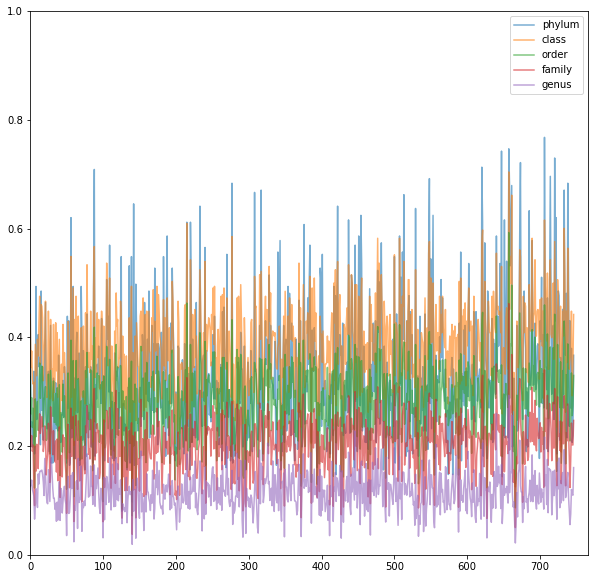

In [88]:
fig, ax = plt.subplots(figsize=(10,10))
ranks_to_plot = ["phylum","class","order","family","genus"]

trends = {x:[] for x in ranks_to_plot}
for i in range(dataframe_full.shape[0]):
    clust = dataframe_full.iloc[i]["cluster"]
    if clust[0] in ["T","h"]:
        continue
    clust_counts = all_cluster_counts[clust]
    for rank in ranks_to_plot:
        trends[rank].append(clust_counts[rank])
for rank in trends:
    ax.plot(trends[rank], label=rank,alpha=0.6)
#ax.plot(np.array(trends["phylum"])/np.array(trends["genus"]))
ax.legend()
ax.set_ylim(0,1)
ax.set_xlim(0,dataframe_full.shape[0])

In [19]:
if "metazoa" not in dataframe.columns.tolist():
    key = {"m":"metazoa", "b":"bacteria", "n":"neither", 
           "a":"archaea", "p":"viridiplantae", "f":"fungi"}
    taxonomy_by_cluster = split_blast_by_domain(blast_path, unique=True, clusters_of_interest=list(dataframe.loc[:,"cluster"]))
    for label in key:
        #print(taxonomy_by_cluster)
        col = [taxonomy_by_cluster[x][label] for x in dataframe.loc[:,"cluster"]]
        dataframe.insert(dataframe.shape[-1], key[label], col)

/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1855284 was translated into 1166323
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 658447 was translated into 38313
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 310683 was translated into 56812
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarn

KeyError: 'metazoa'

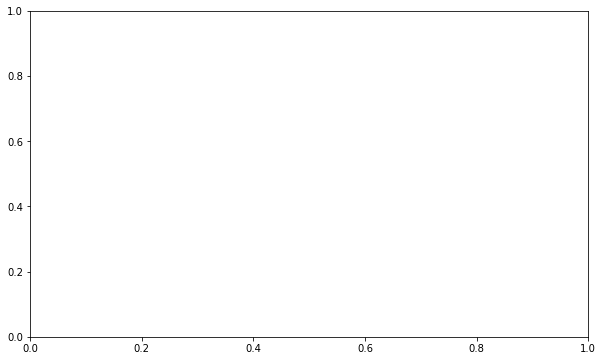

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
col_names = ["metazoa","bacteria","neither","archaea","viridiplantae","fungi"]#,"median"]
#features = [[] for x in range(len(dataframe.loc[:,"cluster"]))]
features = []

for clust in dataframe.loc[:,"cluster"]:
    clust_features = []
    for feature in col_names:
        val = dataframe.loc[dataframe["cluster"] == clust][feature]
        clust_features.append(int(val))
    features.append(clust_features)
norm_features = []

for i in range(len(col_names)):
    feature, name = [x[i] for x in features], col_names[i]
    norm_feature = [val / max(feature) for val in feature]
    norm_features.append(norm_feature)
    if i in [1,2,3,6]:
        continue
    ax.plot(range(len(norm_feature)), norm_feature, label=name)
norm_features_inverse = norm_features.copy()
norm_features = np.array(norm_features).T.tolist()
ax.legend()

[0.49291587 0.17776123 0.12947967 0.10949617 0.05032596 0.04002111]
49.29158662895462


Text(0, 0.5, 'Principal Component 2 (17.78%)')

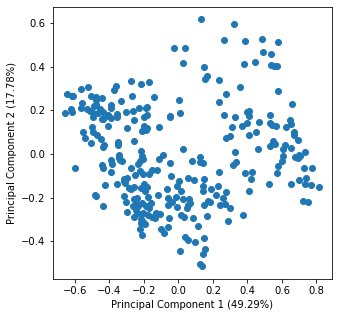

In [100]:
fig, ax = plt.subplots(figsize=(5,5))

#print(features)
pca = PCA(n_components=len(col_names))
pca.fit(norm_features)
transformed = pca.transform(norm_features)
ax.scatter(transformed[:,0], transformed[:,1])
print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
print(pca.explained_variance_ratio_[0]*100)
ax.set_xlabel("Principal Component 1 (%s%%)"%(str(round(pca.explained_variance_ratio_[0]*100, 2))))
ax.set_ylabel("Principal Component 2 (%s%%)"%(str(round(pca.explained_variance_ratio_[1]*100, 2))))

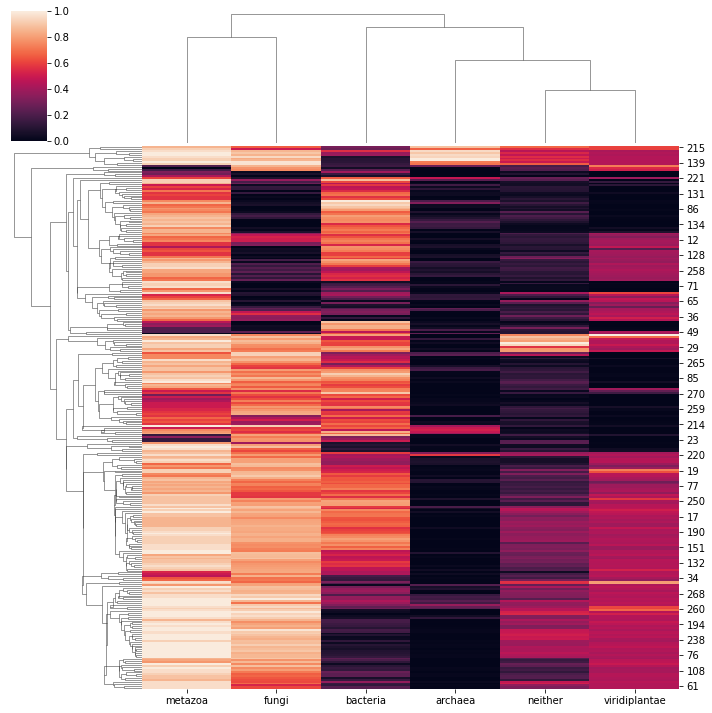

In [98]:
import seaborn as sns
sns.clustermap(pd.DataFrame(norm_features, columns=col_names),standard_scale=1,method="centroid")

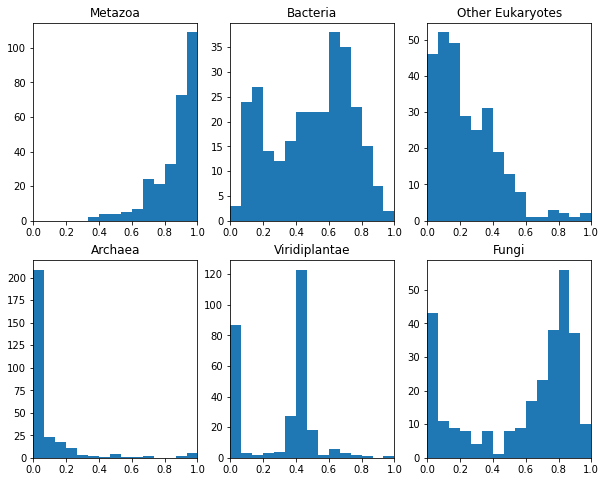

In [101]:
fig, ax = plt.subplots(2,3,figsize=(10,8))
for i in range(len(col_names)):
    ax[i//3, i%3].hist(norm_features_inverse[i], label=col_names[i], bins=15, range=(0,1))
    name = col_names[i].capitalize()
    if name == "Neither": name = "Other Eukaryotes"
    ax[i//3, i%3].set_title(name)
    ax[i//3, i%3].set_xlim(0,1)

In [28]:
# generate file for eggnog annotation
# eggnog mapper v2 10.1093/molbev/msab293
if "eggnog_query.fasta" not in os.listdir():
    num_per_clust = 50
    out_line = ""
    for cluster in dataframe.loc[:,"cluster"]:
        afa_name = alignment_path + cluster + "_1_rn.afa"
        seq_dict = fastaToDictionary(afa_name)
        seq_labels = list(seq_dict.keys())
        for i in range(num_per_clust):
            to_add = seq_labels.pop(np.random.randint(0, len(seq_labels)))
            out_line += ">%s|%s\n%s\n"%(cluster, to_add, seq_dict[to_add].replace("-",""))

    with open("eggnog_query.fasta",'w') as out:
        out.write(out_line)
else:
    print("Query file found")

In [103]:
cluster_annotations = {x:{} for x in dataframe.loc[:,"cluster"]}
with open ("MM_pq85yicv.emapper.annotations.tsv") as f:
    for line in f:
        if line[0] == "#":
            if line[1] != "#":
                labels = line[1:].split()
            continue
        parts = line.split("\t")
        cluster = parts[0].split("|")[0]
        for i in range(1,len(labels)):
            if labels[i] not in cluster_annotations[cluster]:
                cluster_annotations[cluster][labels[i]] = []
            cluster_annotations[cluster][labels[i]].append(parts[i])            
            
kegg_kos = {x:cluster_annotations[x].get("KEGG_ko") for x in cluster_annotations}
kegg_kos = {x:kegg_kos[x] for x in kegg_kos if kegg_kos[x]}
kegg_ko_counts = {x:list_with_separators_to_count_dict(kegg_kos[x]) for x in kegg_kos}

eggnog_ogs = {x:cluster_annotations[x].get("eggNOG_OGs") for x in cluster_annotations}
eggnog_ogs = {x:eggnog_ogs[x] for x in eggnog_ogs if eggnog_ogs[x]}
eggnog_og_counts = {x:list_with_separators_to_count_dict([x.split("|")[0] for x in eggnog_ogs[x]]) for x in eggnog_ogs}

#annotations = {x:cluster_annotations[x].get("Description") for x in cluster_annotations if x in cluster_annotations[x]}
#print(eggnog_og_counts)
for cluster in kegg_ko_counts:
    print(cluster, 
          {x:kegg_ko_counts[cluster][x] for x in kegg_ko_counts[cluster] if kegg_ko_counts[cluster][x] > 15}, 
          {x:eggnog_og_counts[cluster][x] for x in eggnog_og_counts[cluster] if eggnog_og_counts[cluster][x] > 15})

c_1312 {'ko:K01802': 21, 'ko:K03772': 21} {'COG0545@1': 49}
c_13547 {'ko:K00602': 50} {'COG0138@1': 50}
c_11546 {'ko:K04487': 50} {'COG1104@1': 50}
c_11883 {'ko:K00616': 50} {'COG0176@1': 50}
c_3981 {'ko:K12405': 19, '-': 24} {'COG2030@1': 25, 'COG1028@1': 24}
c_3788 {'ko:K01834': 45} {'COG0588@1': 50}
c_6295 {'ko:K02431': 42} {'COG4154@1': 48}
c_12748 {'-': 28} {}
c_7891 {'ko:K00364': 36, 'ko:K00088': 27} {'COG0516@1': 50}
c_712 {'ko:K00128': 35, 'ko:K07249': 16} {'COG1012@1': 50}
c_8247 {'ko:K07023': 47} {'COG1896@1': 48}
c_26458 {'ko:K05606': 48} {'COG0346@1': 49}
c_7922 {'ko:K03635': 47} {'COG0314@1': 49}
c_383 {'ko:K01835': 46} {'COG0033@1': 45}
c_413 {'ko:K00031': 50} {'COG0538@1': 50}
c_13712 {'ko:K00772': 49} {'COG0005@1': 50}
c_1857 {'ko:K00134': 50} {'COG0057@1': 50}
c_20766 {'ko:K00819': 50} {'COG4992@1': 50}
c_3270 {'ko:K00252': 50} {'COG1960@1': 50}
c_5214 {'ko:K01915': 50} {'COG0174@1': 50}
c_16644 {'ko:K01251': 50} {'COG0499@1': 50}
c_15043 {'ko:K01681': 43} {'COG1048@1'

In [20]:
display(HTML(dataframe.to_html()))

,cluster,annotation,conf,first pass,hits,mean,median,range,metazoa,bacteria,neither,archaea,viridiplantae,fungi
0,c_1312,peptidyl-prolyl_cis-trans_isomerase,43.0,0.027497,8138,0.565016,0.321968,0.855444,41,3636,99,3,186,836
1,c_13547,bifunctional_phosphoribosylaminoimidazolecarboxamide_formyltransferase/IMP_cyclohydrolase,35.8,0.034083,9290,0.228049,0.227107,0.076871,31,3862,52,0,2,877
2,c_11546,IscS_subfamily_cysteine_desulfurase,48.8,0.041326,9188,0.452216,0.518073,0.568737,39,4133,139,0,175,867
3,c_11883,transaldolase-like_isoform,2.3,0.053307,9275,0.146041,0.143198,0.031256,39,3884,65,0,3,794
4,c_3981,SDR_family_NAD(P)-dependent_oxidoreductase,22.0,0.053612,9088,0.142950,0.136014,0.239213,37,3350,77,3,137,923
5,c_3788,"2,3-diphosphoglycerate-dependent_phosphoglycerate_mutase",36.9,0.058320,8650,0.202656,0.228919,0.249938,21,5379,123,56,4,35
6,c_6295,ribose_ABC_transporter,11.7,0.059432,5664,0.149447,0.154121,0.189221,24,2708,15,1,2,28
7,c_12748,NACHT_domain-containing_protein,5.3,0.061874,5272,0.215645,0.214590,0.122734,43,660,170,1,183,933
8,c_7891,GMP_reductase,37.1,0.062152,8811,0.103518,0.070277,0.183236,39,4871,49,167,2,7
9,c_712,aldehyde_dehydrogenase_family_protein,29.7,0.062366,6518,1.165708,1.168875,0.181236,38,1472,60,0,195,824
